In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import grad
from torch.autograd.functional import hessian
from tqdm import tqdm
import logging
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
from tqdm import tqdm
from torch.optim import Adam, SGD, LBFGS
from src.verify import check_MC
from src.utils import same_seed, sample_mask, create_mask, extend_mask_coo, symbasis, print_counter_MC
from src.nonconvex import create_loss_fn
from src.search import create_search_proj_fn, create_search_loss_fn, search
torch.set_printoptions(precision=4)

In [2]:
def plot_loss(losses):
    fig, ax = plt.subplots(3, 2, figsize=(20, 30), tight_layout=True)
    loss    = [loss[0] for loss in losses]
    diff    = [loss[1] for loss in losses]
    grad_X  = [loss[2] for loss in losses]
    hess_X  = [loss[3] for loss in losses]
    f_X     = [loss[4] for loss in losses]
    f_Z     = [loss[5] for loss in losses]
    trans   = [loss[6] for loss in losses]
    
    ax[0][0].plot(loss)
    ax[0][1].plot(diff)
    ax[1][0].plot(grad_X)
    ax[1][1].plot(trans)
    ax[2][0].plot(hess_X)
    ax[2][1].plot(f_X, label=r'f(X)')
    ax[2][1].plot(f_Z, label=r'f(Z)')

    ax[0][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][0].set_ylabel(r"$g(X,Z,E)$", fontsize=30)
    ax[0][0].set_title(f"Total Loss vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][0].xaxis.set_tick_params(labelsize=20)
    ax[0][0].yaxis.set_tick_params(labelsize=20)
    ax[0][0].grid()

    ax[0][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[0][1].set_ylabel(r"$f(Z)-f(X)$", fontsize=30)
    ax[0][1].set_title(r"$f(Z)-f(X)$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[0][1].xaxis.set_tick_params(labelsize=20)
    ax[0][1].yaxis.set_tick_params(labelsize=20)
    ax[0][1].grid()

    ax[1][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][0].set_ylabel(r"$\|\nabla_Xf(X)\|_F$", fontsize=30)
    ax[1][0].set_title(r"$\|\nabla_Xf(X)\|_F$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][0].xaxis.set_tick_params(labelsize=20)
    ax[1][0].yaxis.set_tick_params(labelsize=20)
    ax[1][0].set_yscale('log')
    ax[1][0].grid()

    ax[1][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[1][1].set_ylabel(r"$-\|XX^T-ZZ^T\|_F$", fontsize=30)
    ax[1][1].set_title(r"$-\|XX^T-ZZ^T\|_F$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[1][1].xaxis.set_tick_params(labelsize=20)
    ax[1][1].yaxis.set_tick_params(labelsize=20)
    ax[1][1].grid()

    ax[2][0].set_xlabel("# of GD Updates", fontsize=30), 
    ax[2][0].set_ylabel(r"$-\lambda_{min}(\nabla^2_Xf(X))$", fontsize=30)
    ax[2][0].set_title(r"$-\lambda_{min}(\nabla^2_Xf(X))$ vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[2][0].xaxis.set_tick_params(labelsize=20)
    ax[2][0].yaxis.set_tick_params(labelsize=20)
    # ax[2][0].set_yscale('log')
    ax[2][0].grid()

    ax[2][1].set_xlabel("# of GD Updates", fontsize=30), 
    ax[2][1].set_ylabel("Function Value", fontsize=30)
    ax[2][1].set_title("Function Value vs. # of GD Updates", fontsize=25, fontname='Comic Sans MS')
    ax[2][1].xaxis.set_tick_params(labelsize=20)
    ax[2][1].yaxis.set_tick_params(labelsize=20)
    # ax[2][1].set_yscale('log')
    ax[2][1].legend(loc='best')
    ax[2][1].grid()

In [3]:
def compute_X_Z_e(
    variables, 
    top_k, 
    n, 
    r, 
    mu, 
    e_norm, 
    loss_type   = 'MC_max', 
    optim       = 'Adam', 
    iters       = 100, 
    lr          = 0.001, 
    min_lr      = 5e-5, 
    lr_sched    = 'cosine', 
    T           = 1, 
    trans_bound = (-1e-2, -1e2),
    M_type      = 'STE',
):
    parameters = {}
    for name, val  in variables.items():
        if name == 'X':
            X = torch.normal(0.0, torch.ones((n, r))).to(torch.float64).requires_grad_()
            parameters['X'] = X
        elif name == 'Z':
            if val is None:
                Z = torch.normal(0.0, torch.ones((n, r))).to(torch.float64).requires_grad_()
                parameters['Z'] = Z
            else:
                Z = val
        elif name == 'e':
            if val is None:
                e = torch.zeros((n, n), requires_grad=True, dtype=torch.float64)
                parameters['e'] = e
            else:
                e = val
        elif name == 'M':
            M = val
    # check whether we need to train the mask
    P = torch.rand(n*n, dtype=torch.float64)
    if top_k > 0:
        P.requires_grad_()
        parameters['P'] = P
    
    loss_fn = create_loss_fn(
        'MC_PSD', 
        P       = P.detach(),
        Z       = Z.detach(),
        e       = e.detach(),
        top_k   = top_k,
        M_type  = M_type,
        M       = M.detach(),
        sym     = symbasis(n),
        diff    = True
    )
    criterion = create_search_loss_fn(
        loss_fn, 
        loss_type, 
        P = P.detach(),
        Z = Z.detach(),
        e = e.detach(),
    )
    proj_fn = create_search_proj_fn(
        'MC', 
        mu = mu, 
        max_norm = e_norm
    )
    proj_fn(**parameters)
    losses = search(
        parameters,
        criterion,
        proj_fn,
        optim,
        iters,
        lr,
        min_lr,
        lr_sched,
        T,
        trans_bound,
    )
    
    return parameters, losses
    

lr=0.000297, diff=-0.00, dist=-3.68, trans=-0.1027, grad=0.0605, hess=-1.2789, coeff=(0.01,100.00):  47%|████▋     | 4682/10000 [00:31<00:34, 152.21it/s]    WARNING:root:transform loss too small !!


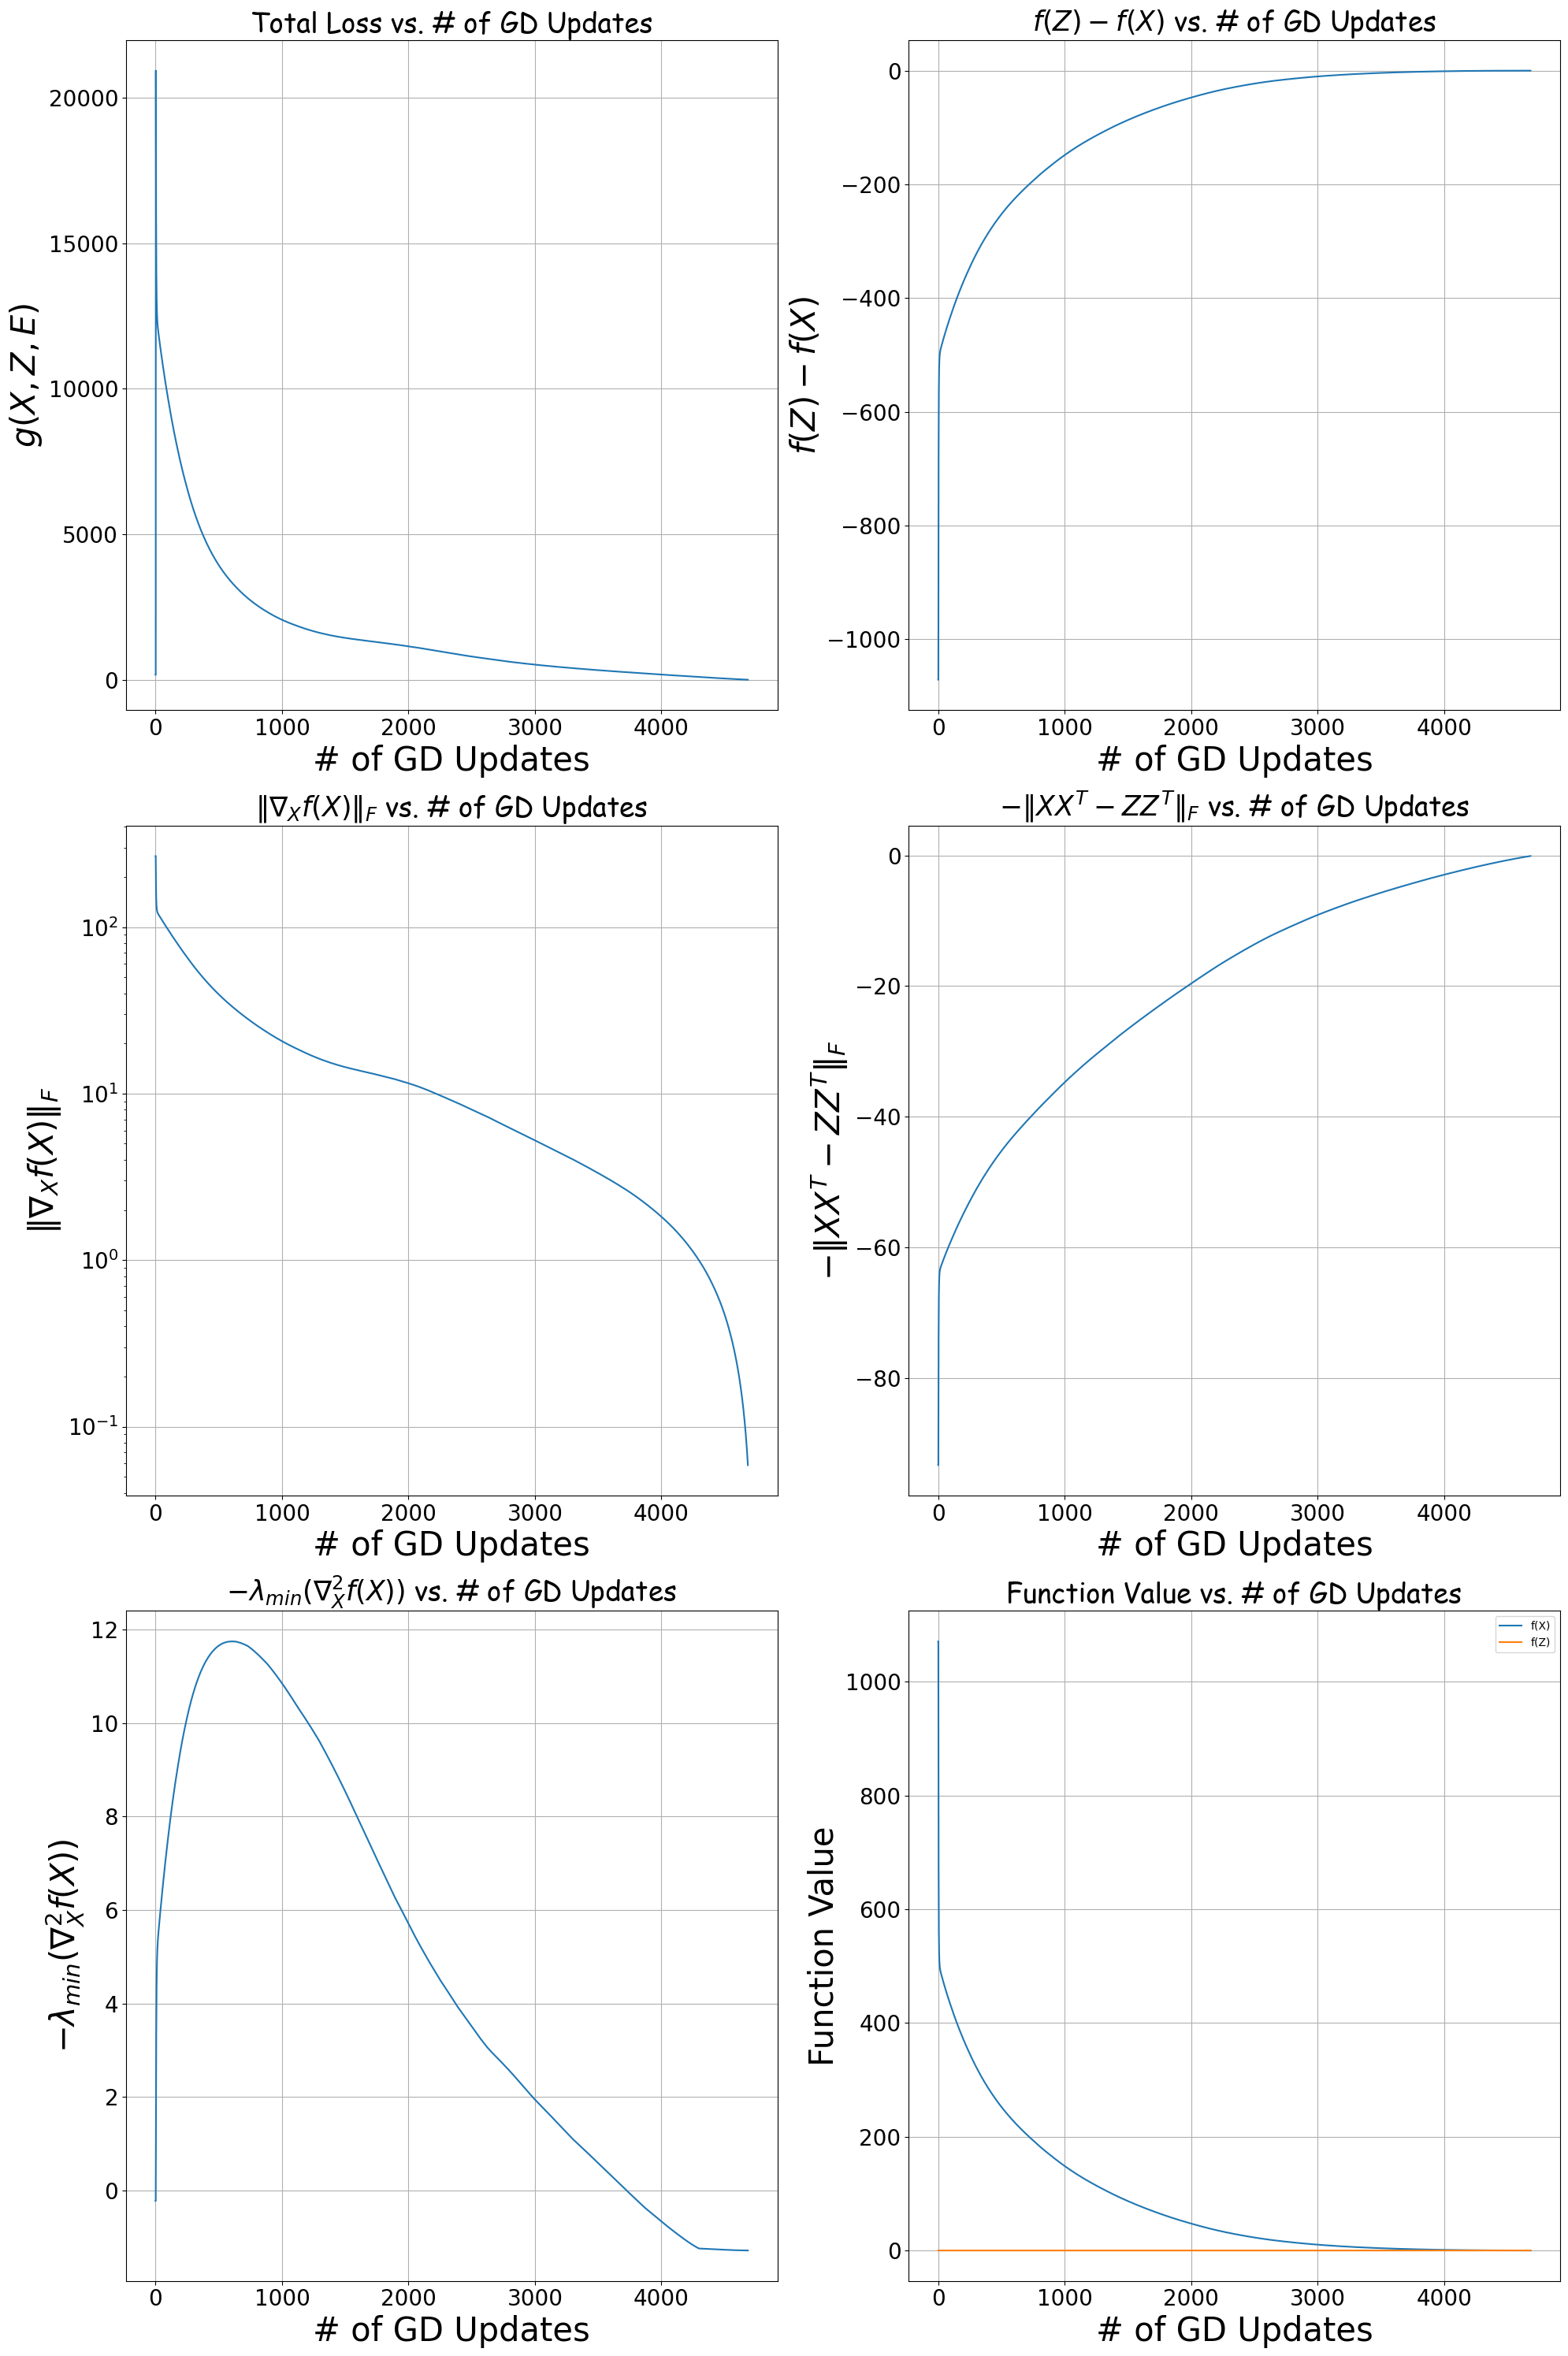

In [5]:
######## Search for (X, Z) ########
n           = 100
r           = 1
p           = 0.5
mu          = 2   # [1, n/r]
e_norm      = 1e-9
loss_type   = 'MC_max'
optim       = 'Adam'
iters       = 10000
lr          = 5e-4
min_lr      = 5e-5
lr_sched    = 'cosine'
T           = 1.5
trans_bound = (-1e-1, -1e4)
top_k       = int(n * n * p)
M_type      = 'STE'

same_seed(34)
M = extend_mask_coo(create_mask(
    # torch.tensor(sample_mask(n, n, p), dtype=torch.float64).to_sparse_coo(), 
    torch.rand((n, n), dtype=torch.float64).to_sparse_coo(),
    top_k, 
    'STE', 
    torch.sparse_coo_tensor(torch.tensor([[],[]]), torch.tensor([]), (n, n))
))
top_k = top_k - len(M.values())
variables = {
    "X": None,
    "Z": None,
    "e": None,
    "M": M,
}
parameters, losses = compute_X_Z_e(
    variables,
    top_k,
    n, 
    r,  
    mu, 
    e_norm, 
    loss_type, 
    optim, 
    iters, 
    lr, 
    min_lr,
    lr_sched, 
    T, 
    trans_bound
)
print_counter_MC("Search for (X, Z)", top_k, parameters, losses, M=M, M_type=M_type)
plot_loss(losses)

Create Symbasis:  0.003571033477783203


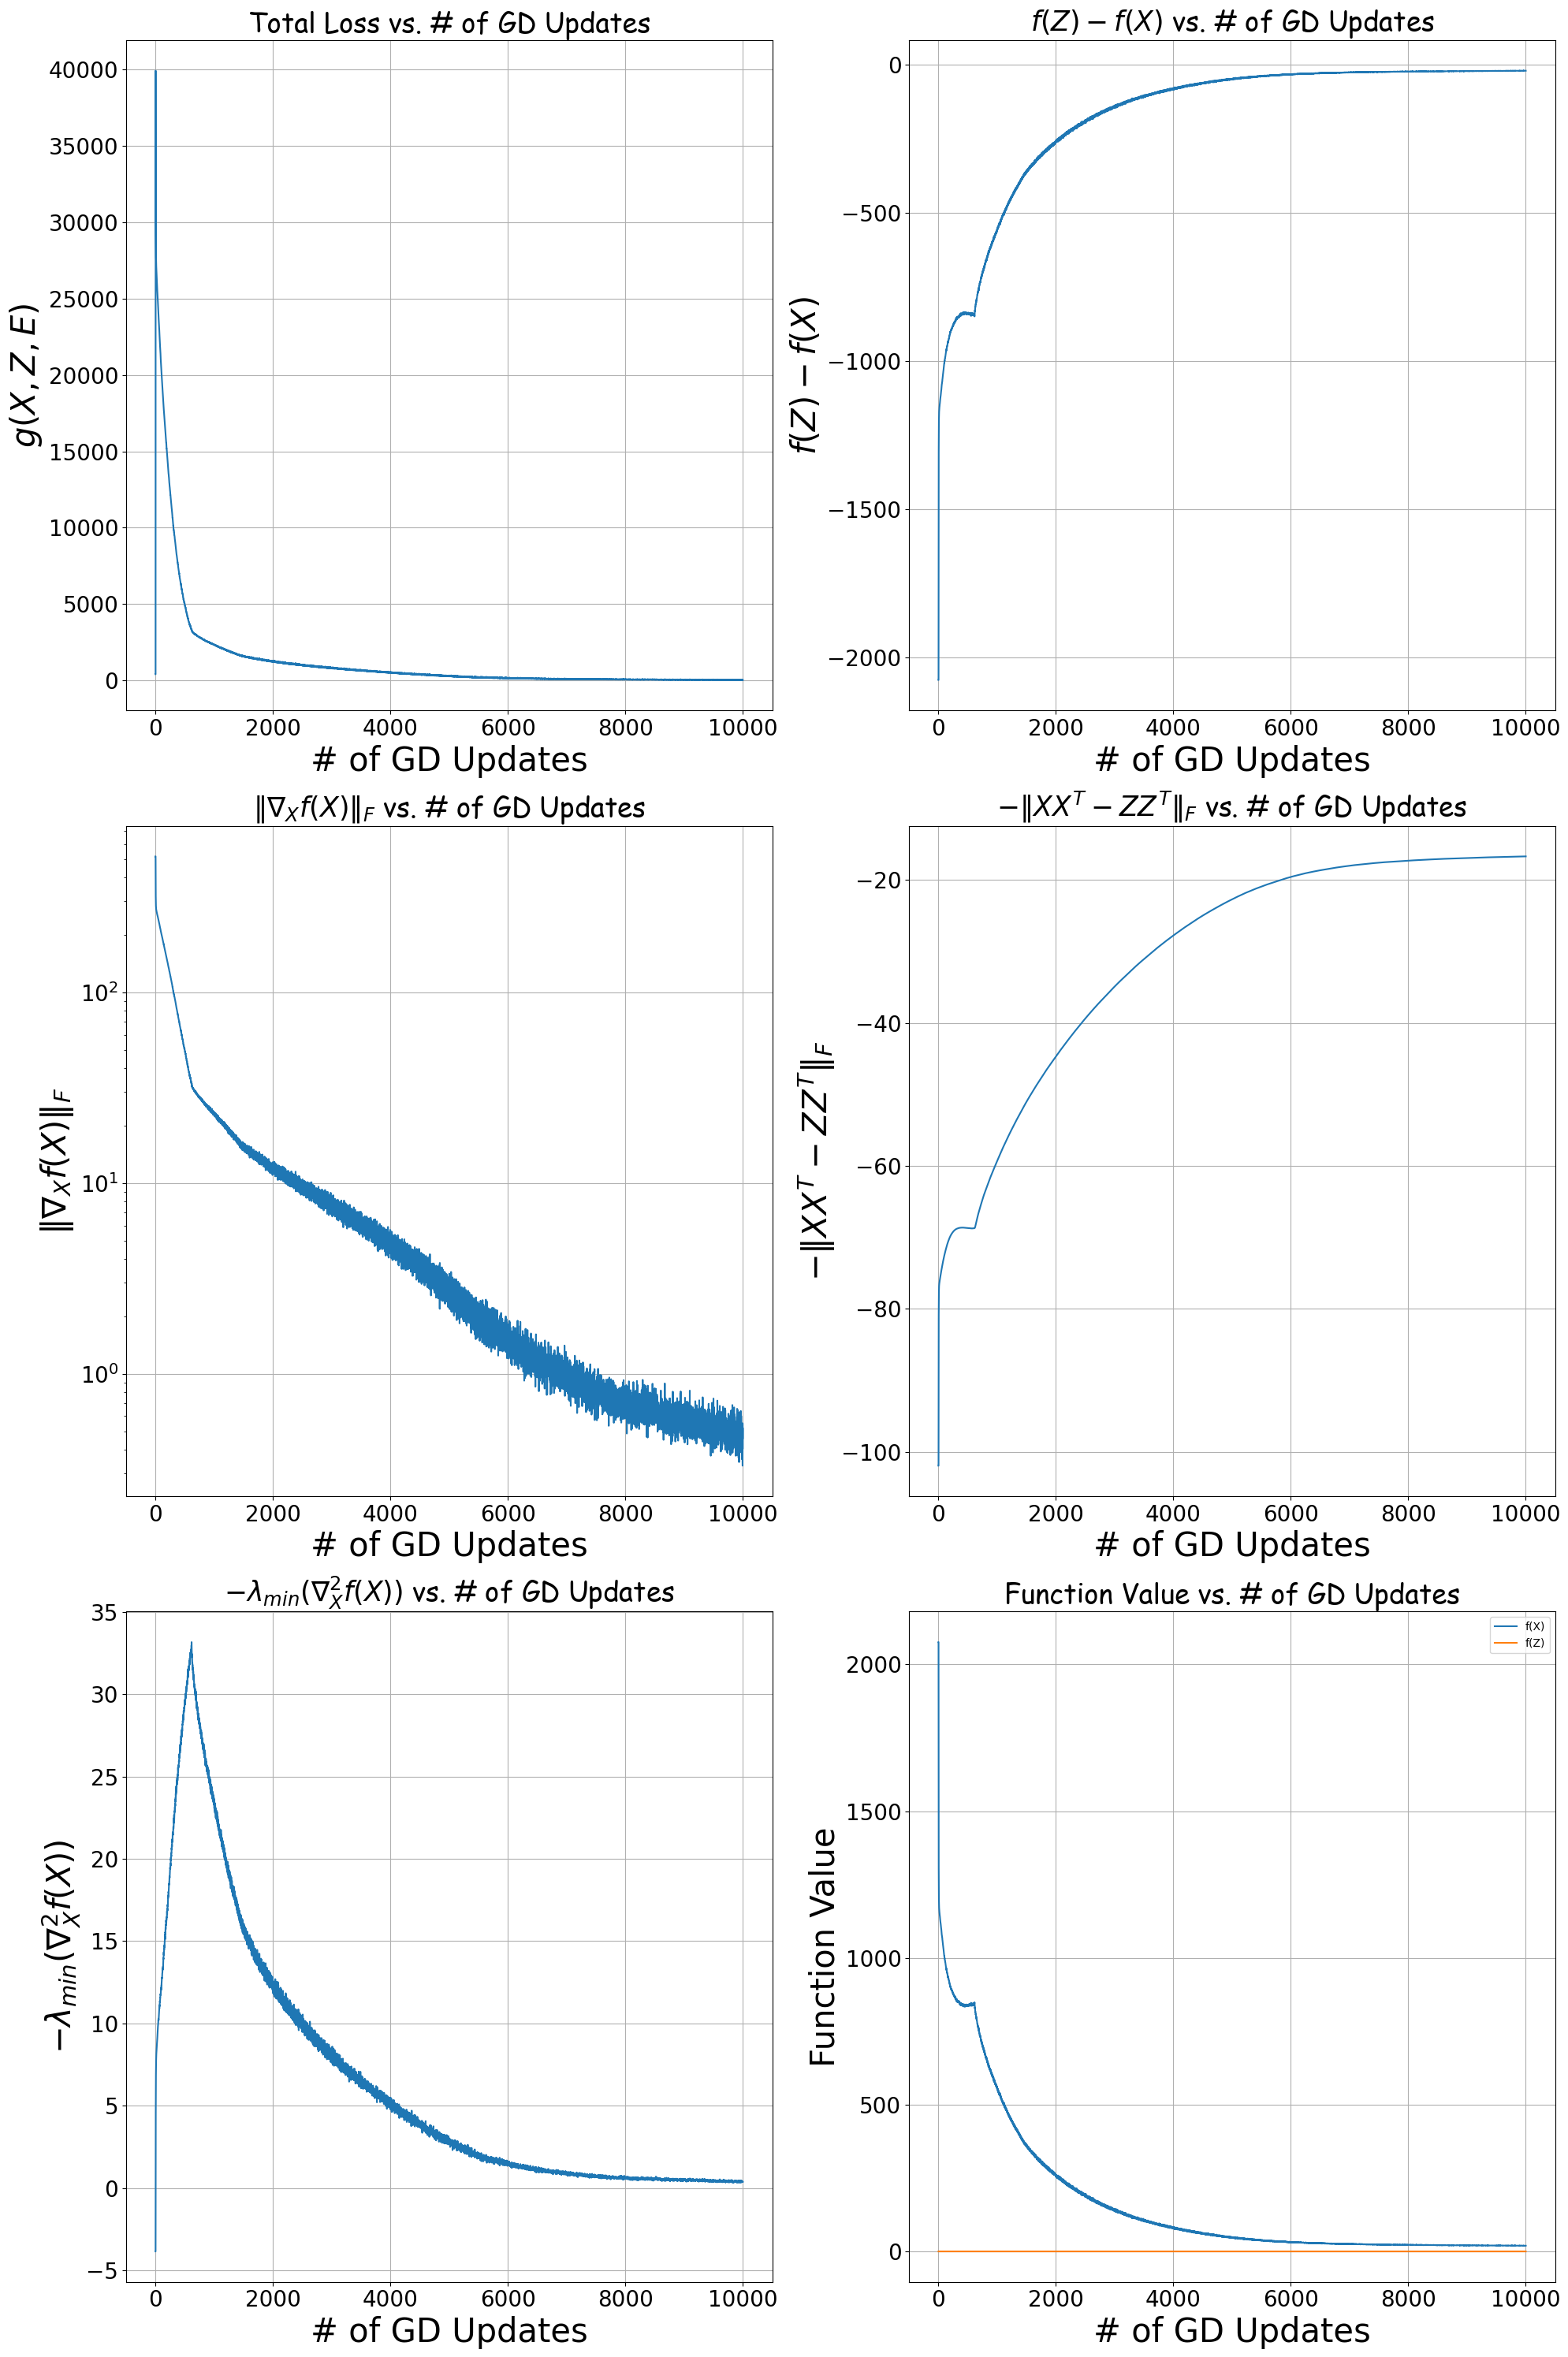

In [ ]:
######## Search for (X, Z, P) ########
n           = 100
r           = 1
p           = 0.8
mu          = 2   # [1, n/r]
e_norm      = 1e-9
loss_type   = 'MC_max'
optim       = 'Adam'
iters       = 10000
lr          = 5e-4
min_lr      = 5e-5
lr_sched    = 'cosine'
T           = 1.5
trans_bound = (-1e-1, -1e3)
top_k       = int(n * n * p)
M_type      = 'STE'

same_seed(0)
M = extend_mask_coo(torch.sparse_coo_tensor(torch.tensor([[],[]]), torch.tensor([], dtype=torch.float64), (n, n)))
top_k = top_k - len(M.values())
# M = torch.zeros((n, n)).to(torch.float64)
# top_k = int(top_k - torch.sum(M == 1).item())
variables = {
    "X": None,
    "Z": None,
    "e": None,
    "M": M,
}
parameters, losses = compute_X_Z_e(
    variables,
    top_k,
    n, 
    r,  
    mu, 
    e_norm, 
    loss_type, 
    optim, 
    iters, 
    lr, 
    min_lr,
    lr_sched, 
    T, 
    trans_bound,
    M_type,
)

# print_counter_MC("Search for (X, Z)", top_k, parameters, losses, M=M, M_type=M_type)
plot_loss(losses)

In [ ]:
def DSE(
    top_k, 
    search_loops, 
    n, 
    r, 
    mu, 
    e_norm,  
    loss_type   = 'A', 
    optim       = 'Adam', 
    iters       = 100, 
    lr          = 0.001, 
    min_lr      = 5e-5, 
    lr_sched    = 'cosine', 
    T           = 1, 
    trans_bound = (-1e-1, -1e2),
    seed        = 0,
    M_type      = 'STE',
    M           = None,         # COO
):
    same_seed(seed)
    for i in range(search_loops):
        if M is None:
            mask = extend_mask_coo(create_mask(
                torch.rand((n, n), dtype=torch.float64).to_sparse_coo(),
                top_k, 
                'STE', 
                torch.sparse_coo_tensor(torch.tensor([[],[]]), torch.tensor([]), (n, n))
            ))
        else:
            mask = M
        variables = {
            "X": None,
            "Z": None,
            "e": None,
            "M": mask,
        }
        _top_k = top_k - len(mask.values())
        parameters, losses = compute_X_Z_e(
            variables,
            _top_k,
            n, 
            r,  
            mu,
            e_norm, 
            loss_type, 
            optim, 
            iters, 
            lr, 
            min_lr,
            lr_sched,
            T,
            trans_bound,
            M_type
        ) 
        if len(losses) < iters + 1: # Early Stop
            continue
        # print_counter_MC(f"Search Loop {i}", _top_k, parameters, losses, M=mask, M_type=M_type)
        flag = check_MC(
            parameters,
            _top_k,
            mu, 
            PSD     = True,
            M       = mask,
            M_type  = M_type
        )
        

In [ ]:
n           = 5
r           = 1
p           = 0.8
mu          = 2   # [1, n/r]
e_norm      = 1e-18
loss_type   = 'MC_max'
optim       = 'Adam'
iters       = 10000
lr          = 5e-4
min_lr      = 5e-5
lr_sched    = 'cosine'
T           = 1.5
trans_bound = (-1e-1, -1e2)
sear_loops  = 10
top_k       = int(n * n * p)
M           = None # torch.zeros((n, n))
seed        = 0
M_type      = 'STE'

DSE(
    top_k,
    sear_loops, 
    n, 
    r, 
    mu, 
    e_norm, 
    loss_type, 
    optim, 
    iters, 
    lr, 
    min_lr, 
    lr_sched, 
    T, 
    trans_bound,
    seed, 
    M_type,
    M,
)

TypeError: create_mask() takes 4 positional arguments but 5 were given

In [ ]:
x = torch.randn(3, 4, requires_grad=True).to_sparse_coo()
y = torch.randn(3, 4, requires_grad=True).to_sparse_coo()
print(x+y)
mask = torch.tensor(np.random.binomial(1, 0.5, (3, 4))) == 1
y = torch.masked_select(x, mask)
print(y)
print(y.requires_grad)

tensor(indices=tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2],
                       [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]]),
       values=tensor([ 2.0550, -1.0256,  2.8938, -0.0280, -0.9200, -0.1060,
                       1.6273,  0.5733,  2.3366, -1.6676,  1.7230,  3.0153]),
       size=(3, 4), nnz=12, layout=torch.sparse_coo, grad_fn=<AddBackward0>)


NotImplementedError: Could not run 'aten::masked_select' with arguments from the 'SparseCPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::masked_select' is only available for these backends: [CPU, MPS, Meta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastMTIA, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/RegisterCPU_0.cpp:5545 [kernel]
MPS: registered at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/RegisterMPS_0.cpp:24395 [kernel]
Meta: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/MetaFallbackKernel.cpp:23 [backend fallback]
BackendSelect: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:194 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:479 [backend fallback]
Functionalize: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/NamedRegistrations.cpp:11 [kernel]
Conjugate: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:100 [backend fallback]
AutogradOther: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:20142 [autograd kernel]
AutogradCPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:20142 [autograd kernel]
AutogradCUDA: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:20142 [autograd kernel]
AutogradHIP: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:20142 [autograd kernel]
AutogradXLA: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:20142 [autograd kernel]
AutogradMPS: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:20142 [autograd kernel]
AutogradIPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:20142 [autograd kernel]
AutogradXPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:20142 [autograd kernel]
AutogradHPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:20142 [autograd kernel]
AutogradVE: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:20142 [autograd kernel]
AutogradLazy: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:20142 [autograd kernel]
AutogradMTIA: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:20142 [autograd kernel]
AutogradPrivateUse1: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:20142 [autograd kernel]
AutogradPrivateUse2: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:20142 [autograd kernel]
AutogradPrivateUse3: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:20142 [autograd kernel]
AutogradMeta: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:20142 [autograd kernel]
AutogradNestedTensor: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/VariableType_2.cpp:20142 [autograd kernel]
Tracer: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/TraceType_2.cpp:17801 [kernel]
AutocastCPU: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/autocast_mode.cpp:322 [backend fallback]
AutocastMTIA: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/autocast_mode.cpp:466 [backend fallback]
AutocastXPU: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/autocast_mode.cpp:504 [backend fallback]
AutocastMPS: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchRulesBinaryOps.cpp:352 [kernel]
BatchedNestedTensor: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/TensorWrapper.cpp:208 [backend fallback]
PythonTLSSnapshot: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:202 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:475 [backend fallback]
PreDispatch: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:206 [backend fallback]
PythonDispatcher: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:198 [backend fallback]
